# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
P = Project('..')

In [3]:
SP.start()

Setting default log level to "

23/05/05 09:39:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data

### Boundary

In [15]:
bound = gpd.read_parquet(P.data / 'export/boundary.parquet').set_crs(CRS_DEG).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:4326


,geoid,aland,awater,geometry,scale,name
,<category>,<int64>,<int64>,<geometry>,<object>,<object>
0,181379685003,2566010,39626,"POLYGON ((-85.20815 39.304011, -85.208134 39.3...",BG,None


### EJScreen

In [5]:
ejs = pd.read_parquet(P.data / 'export/ejscreen.parquet').disp()

544,908 rows x 7 cols; Memory: 8.5 MiB


,scale,ej_or_ses,base_or_derived,value_or_pctile,variable,geoid,value
,<category>,<category>,<category>,<category>,<category>,<category>,<float64>
0,Tract,SES,Base,Value,Total population,18001030100,4975.0


### AAA Access

In [6]:
aaa = pd.read_parquet(P.data / 'export/aaa.parquet').disp()

12,001,392 rows x 8 cols; Memory: 218.1 MiB


,scale,mode,tt_thresh,is_rac,category,subcategory,geoid,num_jobs
,<category>,<category>,<int64>,<bool>,<category>,<category>,<category>,<int32>
0,BG,Bike,5,False,Overall,Total,180010301001,8


### POI access

In [7]:
poiXs = pd.read_parquet(P.data / 'export/poi_access.parquet').disp()

1,895,487 rows x 6 cols; Memory: 38.6 MiB


,scale,mode,tt_thresh,poi_kind,geoid,num_pois
,<category>,<category>,<int64>,<category>,<category>,<int64>
0,County,Auto,60,Education,18001,426


# Explore

## Correlation

<Axes: >

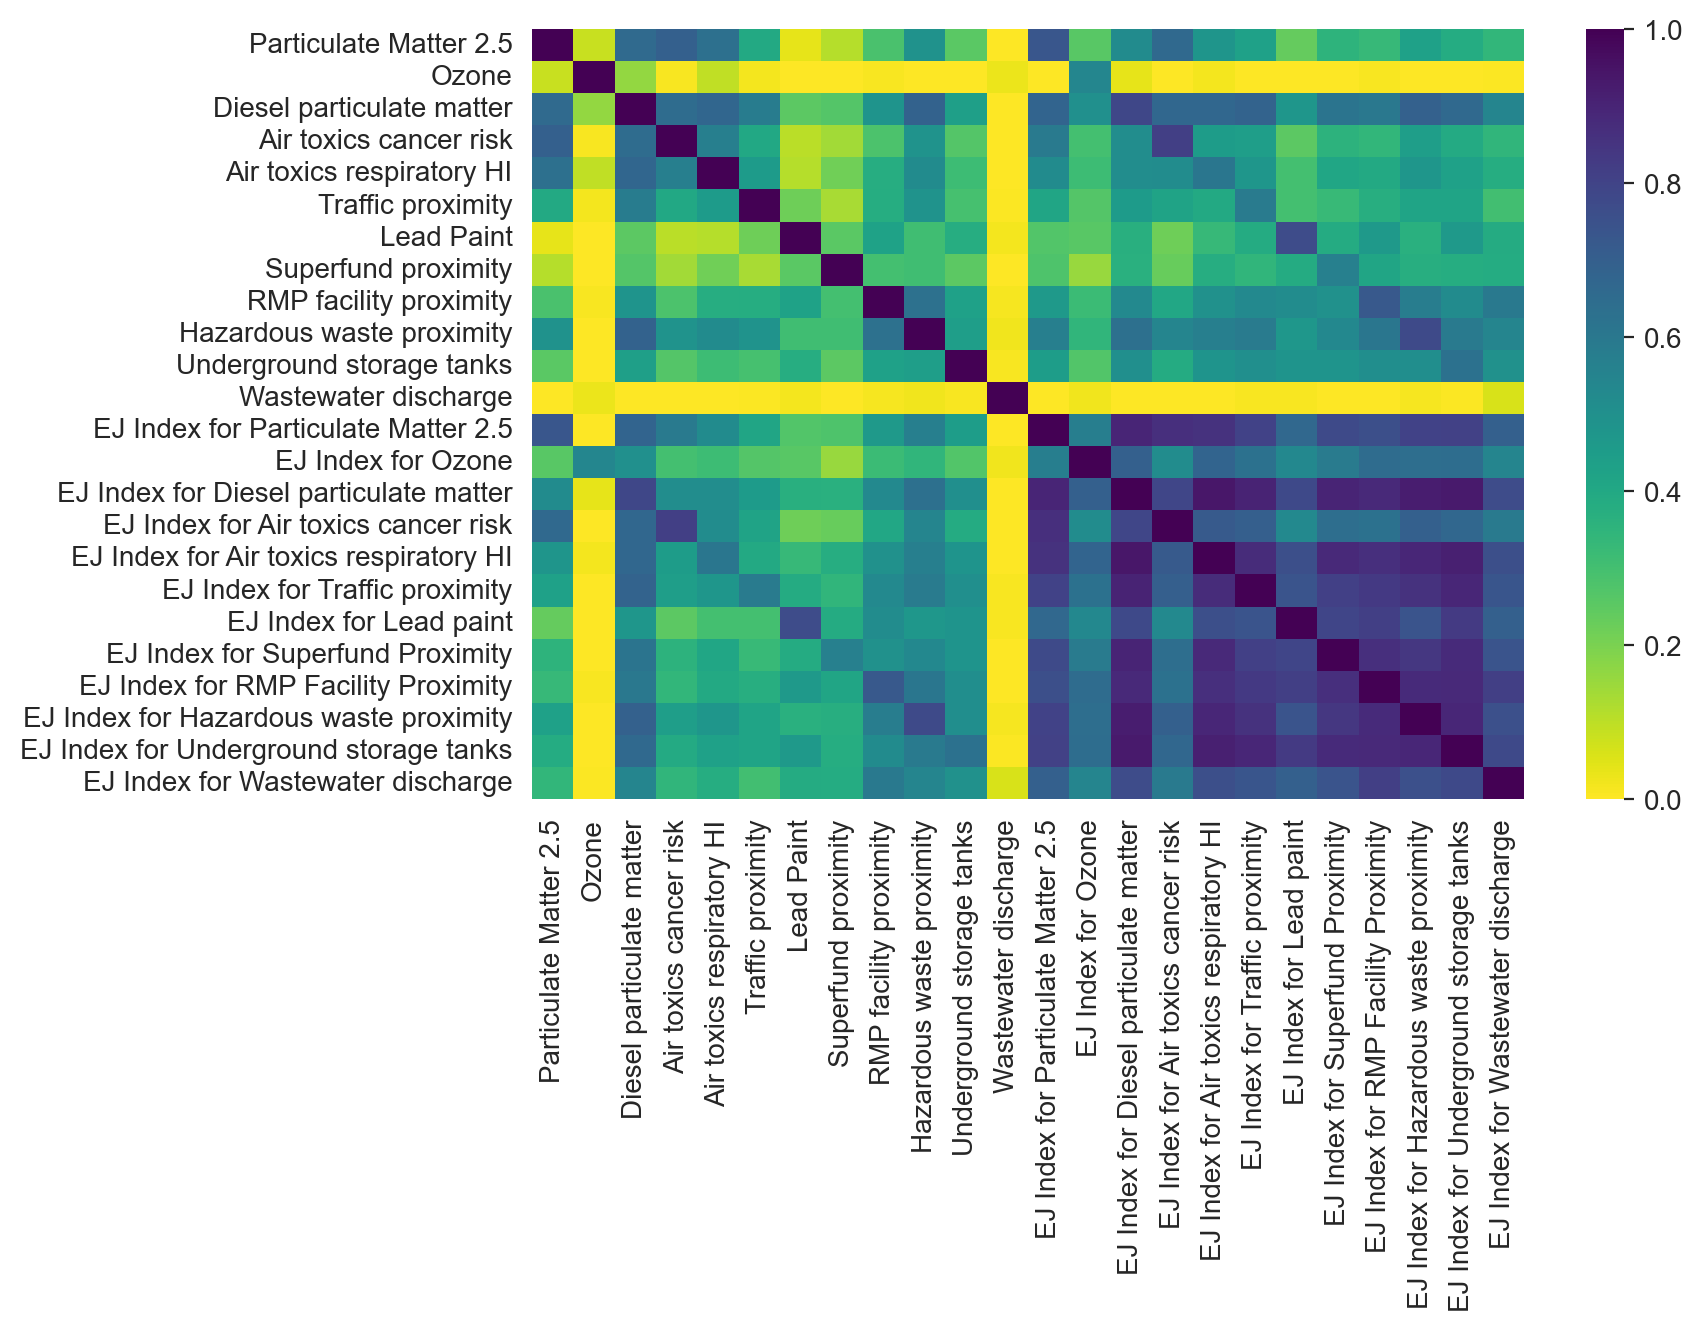

In [8]:
def plot_corr_ejs(query, exclude_vars=[], df=ejs, vmin=0, vmax=1, 
                  cmap='viridis_r', size=(8, 5), dpi=100):
    if isinstance(query, dict):
        query = ' & '.join([f'{k} == "{v}"' for k, v in query.items()])
    df = df.query(query).pipe(lambda df: df[~df['variable'].isin(exclude_vars)]).dropna()
    df = df.pivot(index='geoid', columns=['base_or_derived', 'variable'], values='value')
    df = df.droplevel(0, axis=1)
    ax = U.plot(size=size, dpi=dpi)
    ax = sns.heatmap(df.corr(), ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel(''); ax.set_ylabel('')
    return ax

exclude_vars = ['Number of EJ Indexes exceeeding 80 percentile']
x = plot_corr_ejs(dict(scale='Tract', ej_or_ses='EJ', value_or_pctile='Value'), exclude_vars, dpi=200); x

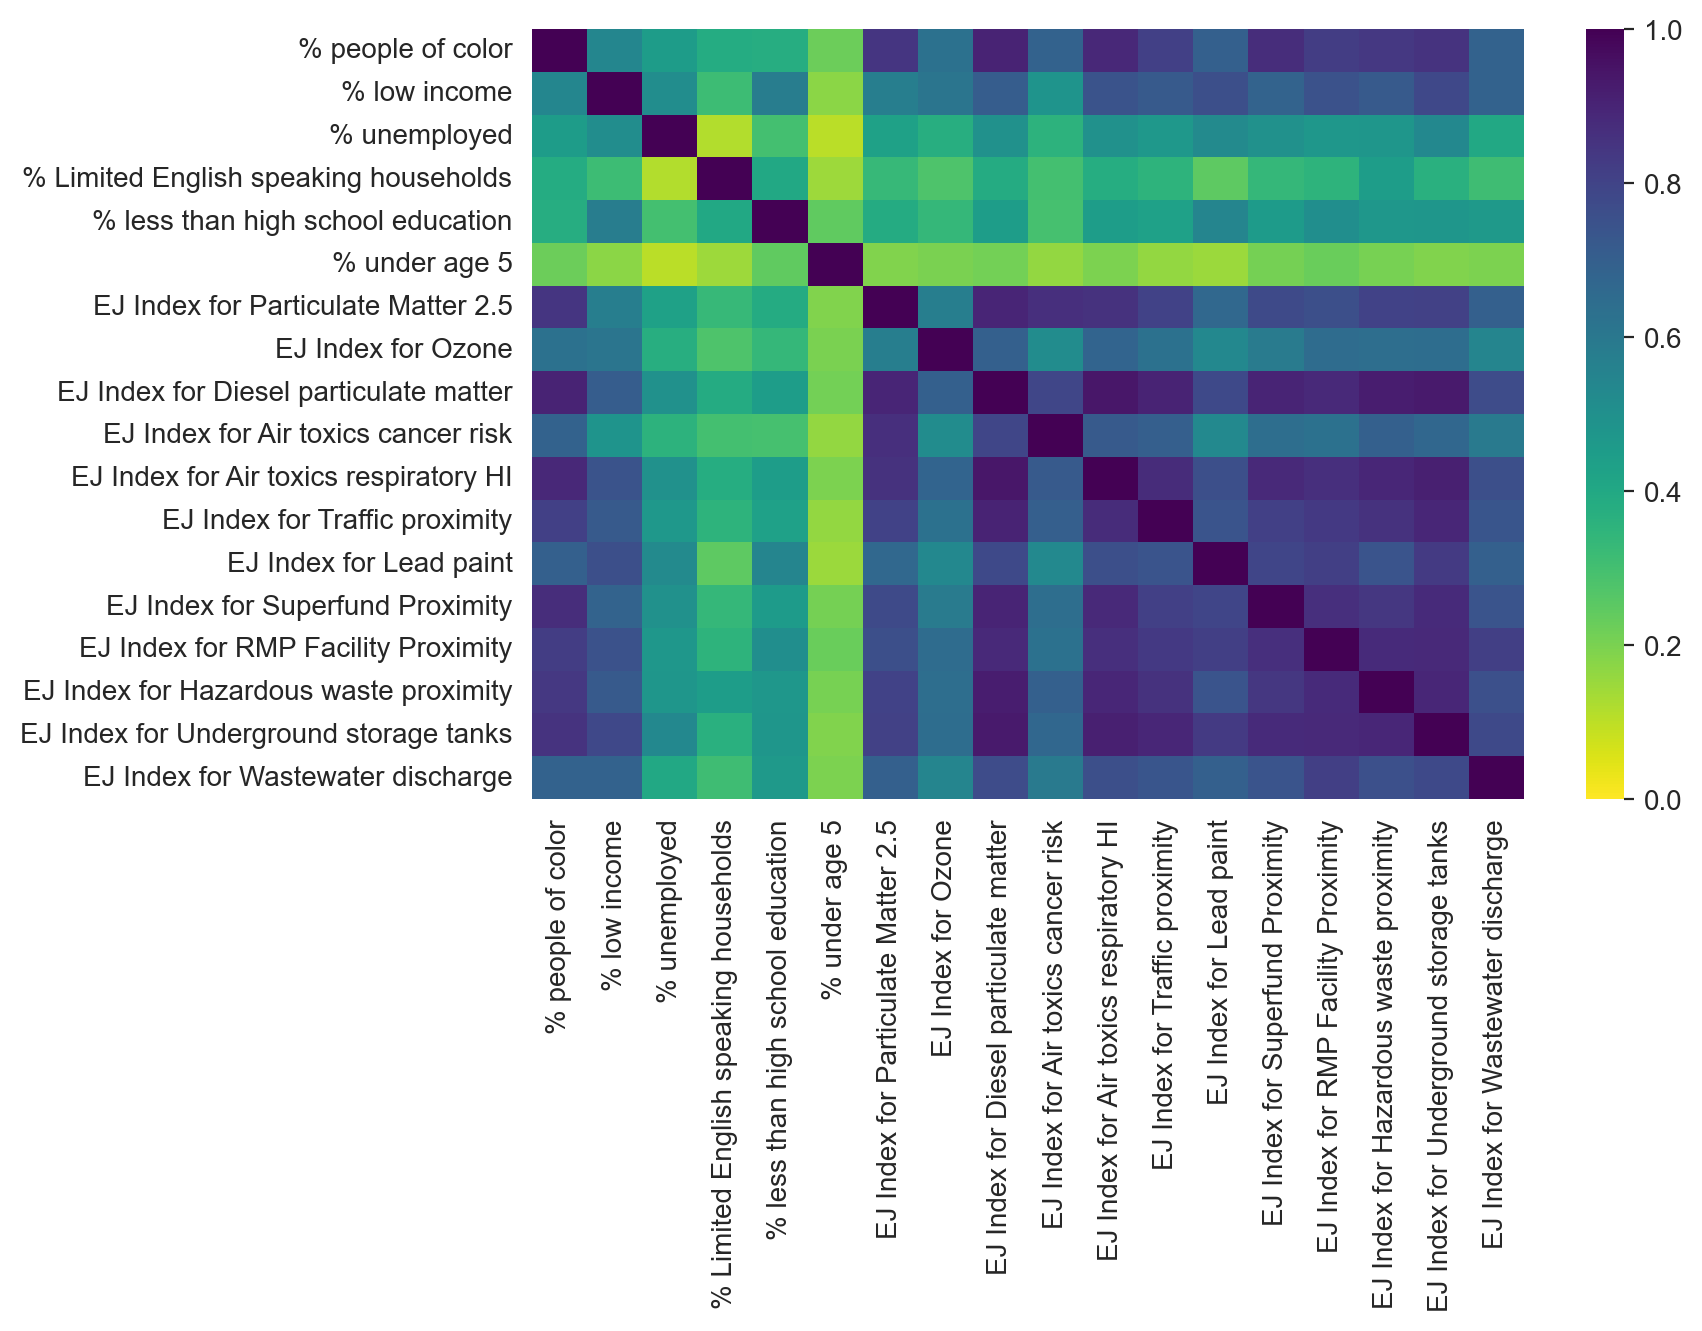

In [9]:
x = plot_corr_ejs(dict(scale='Tract', base_or_derived='Derived', value_or_pctile='Value'), 
                  exclude_vars, dpi=200)

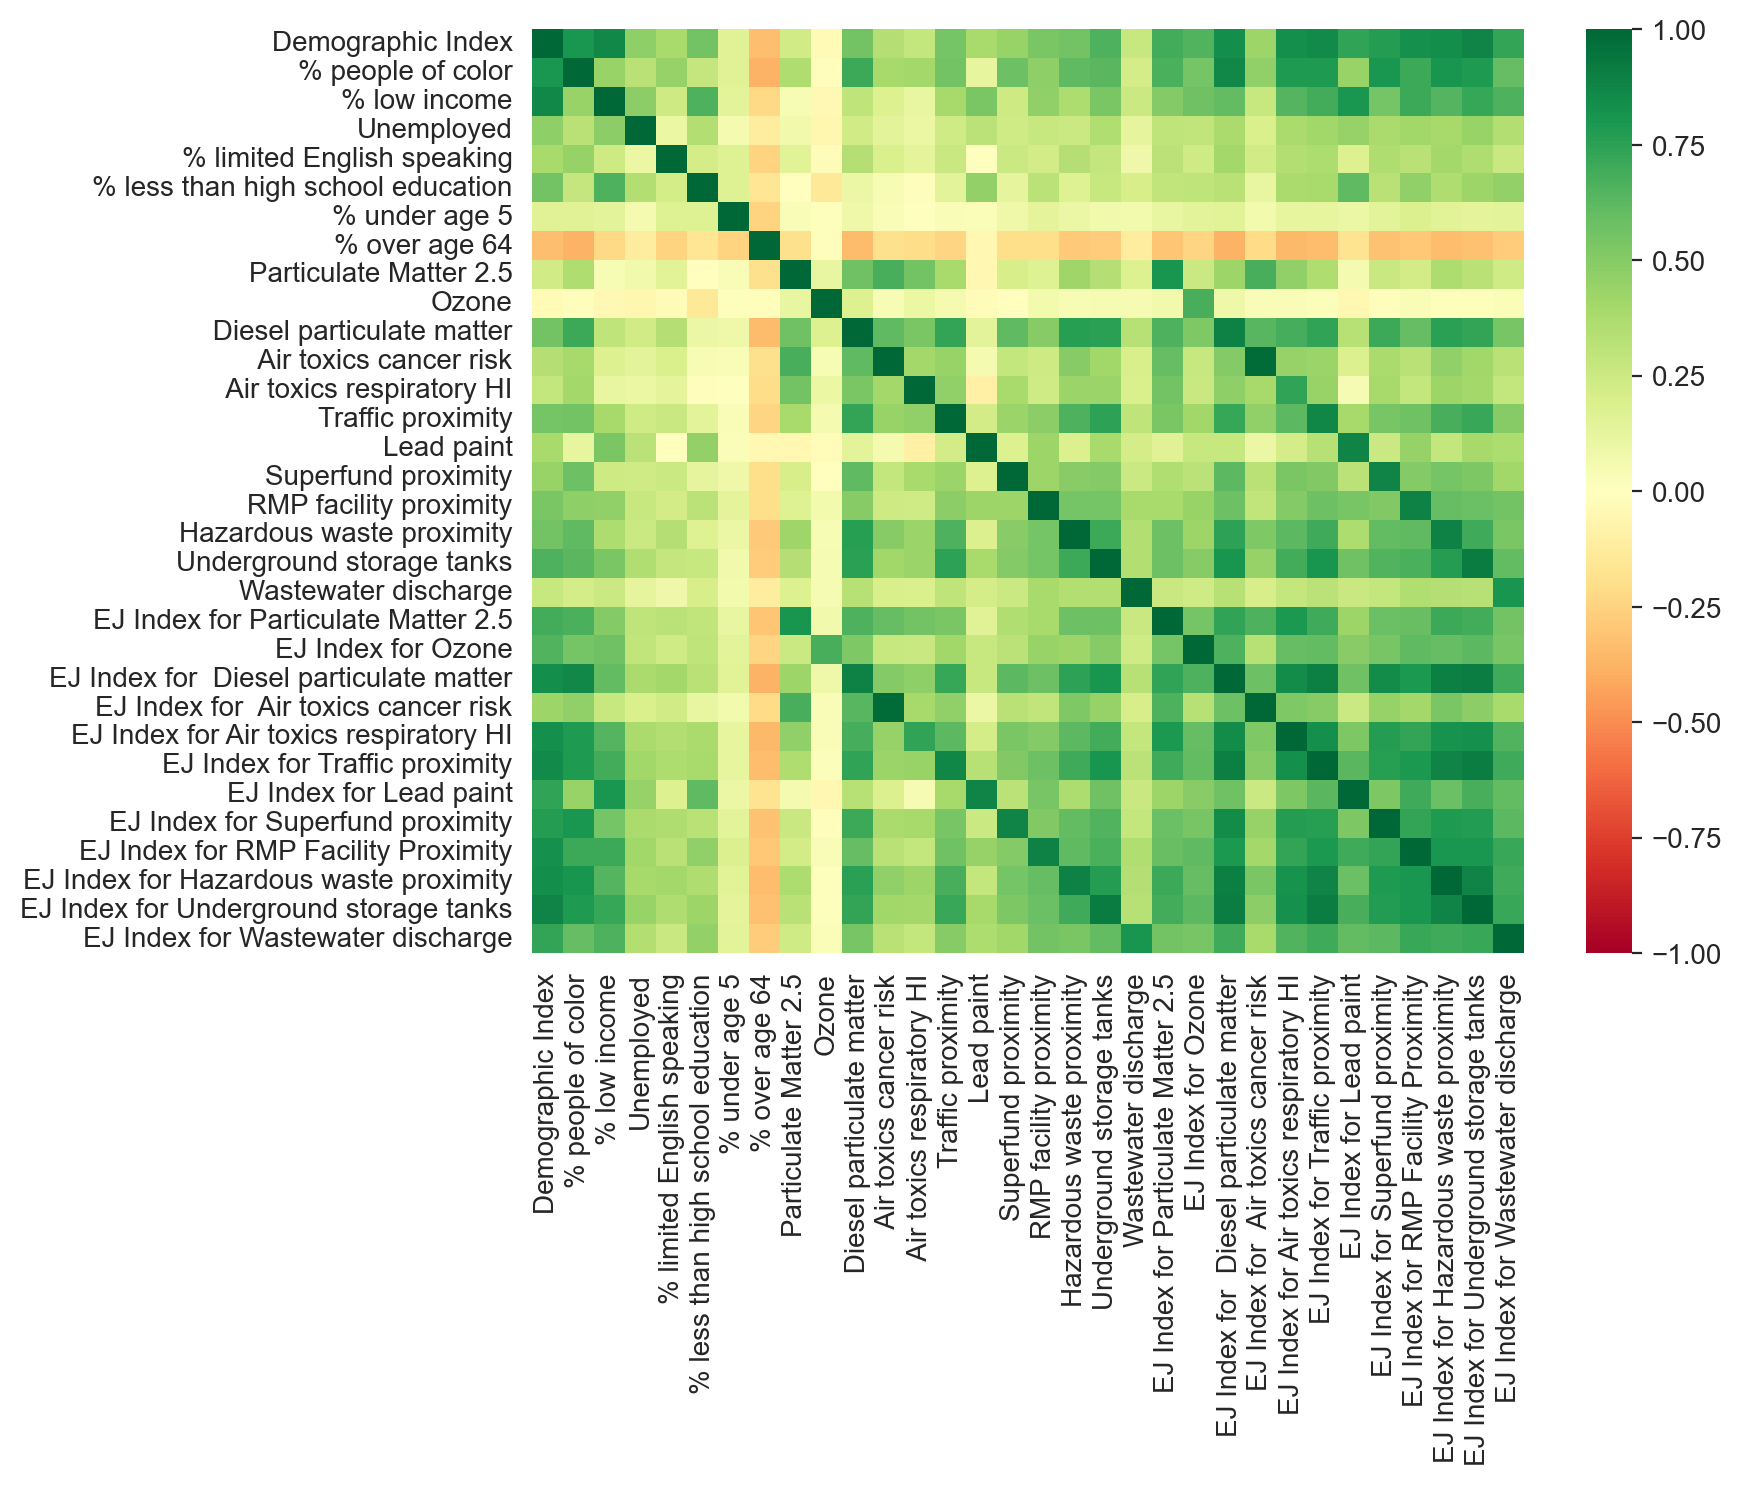

In [10]:
x = plot_corr_ejs(dict(scale='Tract', value_or_pctile='Percentile'), 
                  exclude_vars, vmin=-1, cmap='RdYlGn', dpi=200, size=(8, 6))

## Plot maps

In [11]:
indy_counties = ['Boone','Brown','Hamilton','Hancock','Hendricks','Johnson','Madison','Marion','Morgan','Putnam','Shelby']

In [12]:
bgs = (bound.query('scale=="BG"').assign(county_fips = lambda df: df['geoid'].str.slice(0, 5))
       .merge(bound.merge(Pdf({'name': indy_counties}))['geoid'].rename('county_fips'))
       .set_crs(CRS_DEG)).disp()

1,178 rows x 7 cols; Memory: 0.9 MiB; CRS: EPSG:4326


,geoid,aland,awater,geometry,scale,name,county_fips
,<category>,<int64>,<int64>,<geometry>,<object>,<object>,<object>
0,180816112003,50259791,412098,"POLYGON ((-86.02792 39.37482, -86.027911 39.37...",BG,None,18081


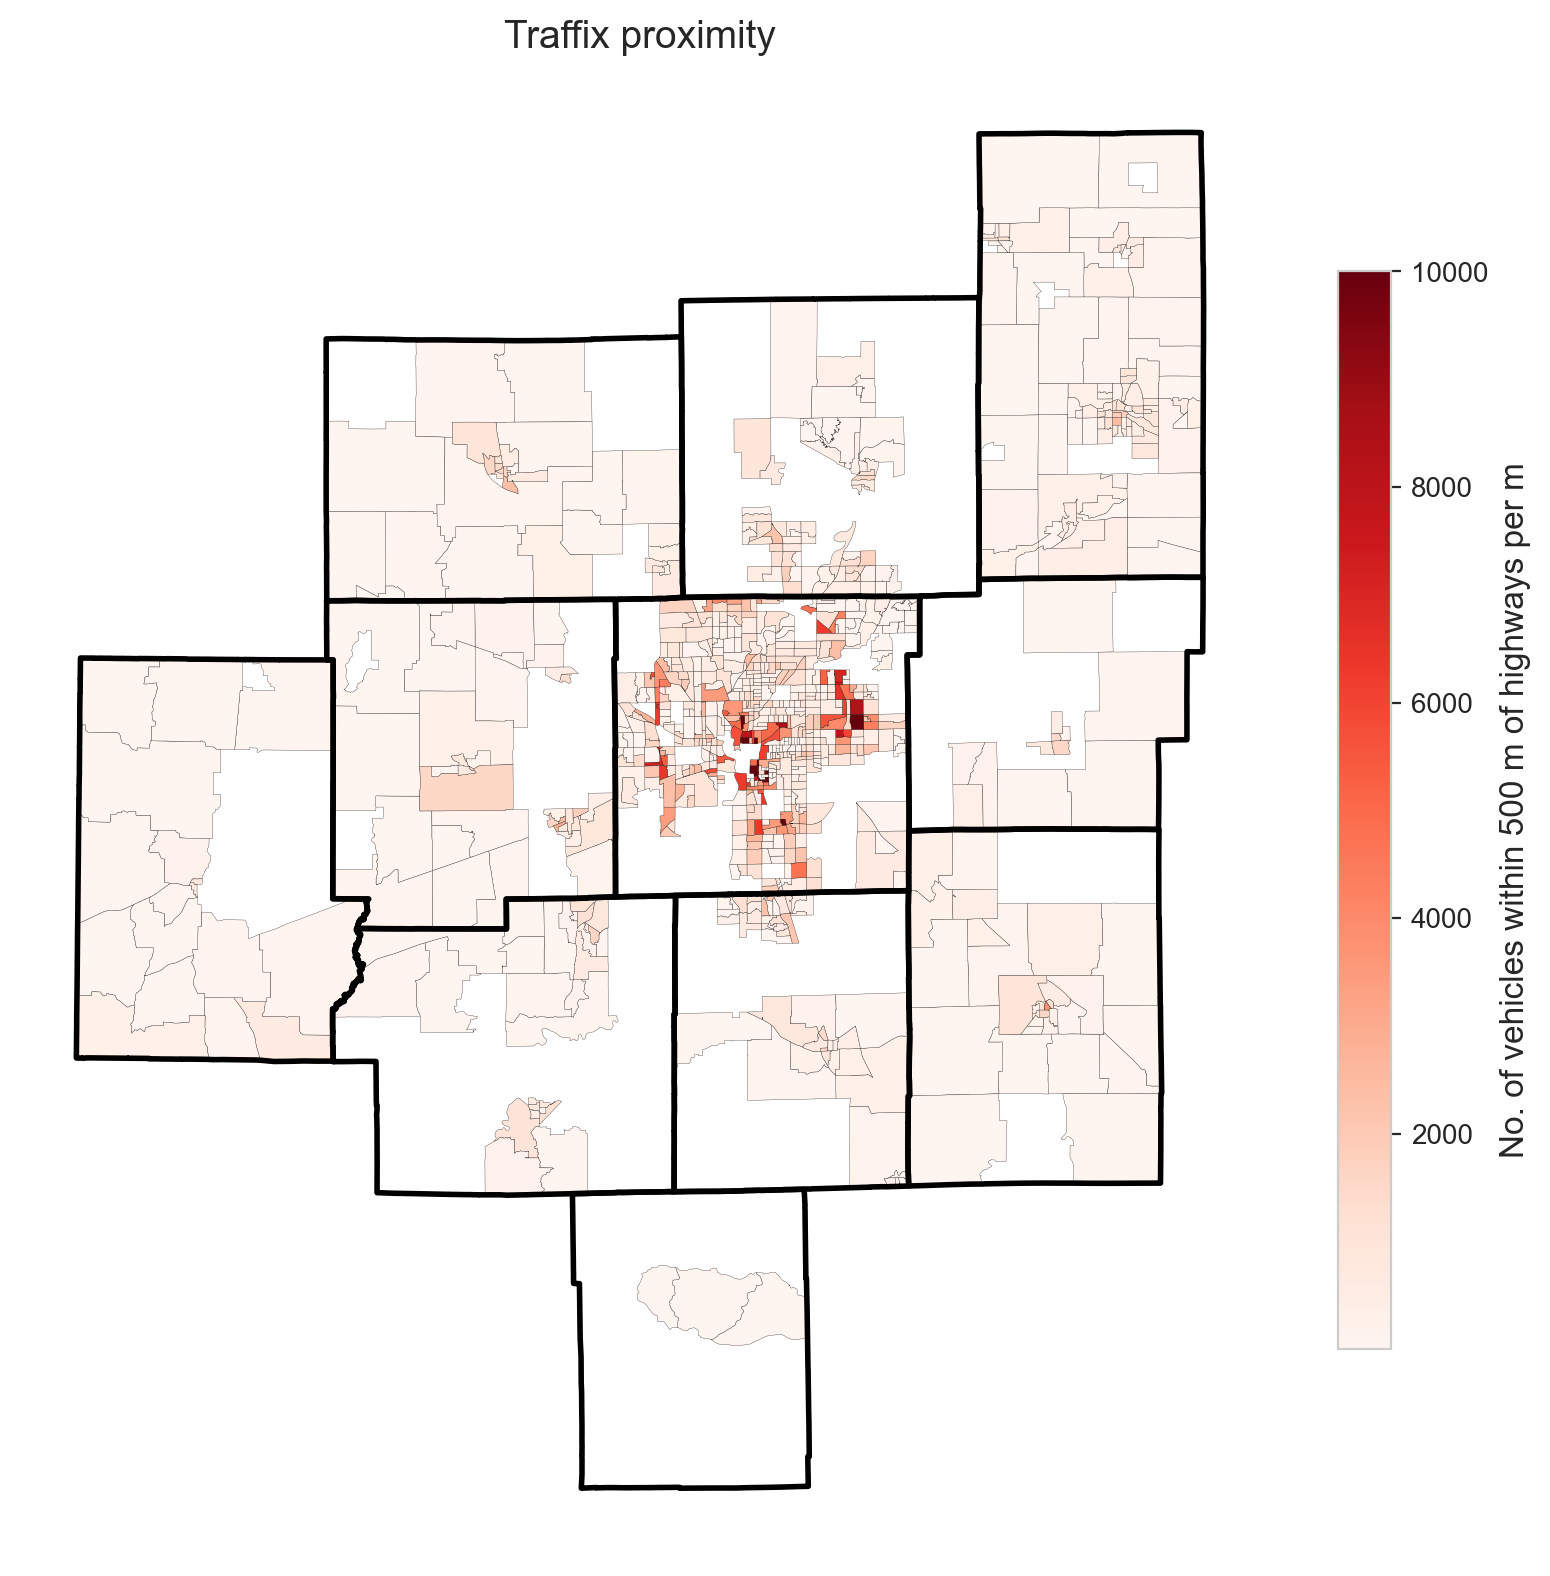

In [13]:
ax = U.plot(size=(10, 10), dpi=200, axoff=1, title='Traffix proximity')
bgs.to_crs(CRS_M).merge(
    ejs.query('scale=="BG" & variable=="Traffic proximity" & value_or_pctile=="Value"'))\
.plot(ax=ax, column='value', cmap='Reds', linewidth=0.1, edgecolor='k', vmax=10000,
      legend=True, legend_kwds=dict(shrink=0.7, label='No. of vehicles within 500 m of highways per m'));
bound.merge(Pdf({'name': indy_counties})).to_crs(CRS_M)\
.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2);

# Atlas